### Entropy Pooling

Black Litterman Portfolio optimization의 연장선에서 EP가 연구되었다

In [1]:
import numpy as np
from scipy.optimize import minimize, Bounds
from typing import Tuple

def entropy_pooling(
        p: np.ndarray, A: np.ndarray, b: np.ndarray, G: np.ndarray = None,
        h: np.ndarray = None, method: str = None
) -> np.ndarray:
    """엔트로피 풀링 후방 확률 계산 함수.

    Args:
        p: 사전 확률 벡터, (S, 1)의 형태.
        A: 평등 제약 조건 행렬, (M, S)의 형태.
        b: 평등 제약 조건 벡터, (M, 1)의 형태.
        G: 부등식 제약 조건 행렬, (N, S)의 형태. 기본값은 None.
        h: 부등식 제약 조건 벡터, (N, 1)의 형태. 기본값은 None.
        method: 최적화 방법. {'TNC', 'L-BFGS-B'} 중 선택. 기본값은 'TNC'.

    Returns:
        후방 확률 벡터, (S, 1)의 형태.
    """
    if method is None:
        method = 'TNC'
    elif method not in ('TNC', 'L-BFGS-B'):
        raise ValueError(f'지원되지 않는 방법 {method}. TNC 또는 L-BFGS-B를 선택하세요.')

    len_b = len(b)
    if G is None:
        lhs = A
        rhs = b
        bounds = Bounds([-np.inf] * len_b, [np.inf] * len_b)
    else:
        lhs = np.vstack((A, G))
        rhs = np.vstack((b, h))
        len_h = len(h)
        bounds = Bounds([-np.inf] * len_b + [0] * len_h, [np.inf] * (len_b + len_h))

    log_p = np.log(p)
    dual_solution = minimize(
        _dual_objective, x0=np.zeros(lhs.shape[0]), args=(log_p, lhs, rhs),
        method=method, jac=True, bounds=bounds, options={'maxfun': 10000}
    )
    q = np.exp(log_p - 1 - lhs.T @ dual_solution.x[:, np.newaxis])
    return q

def _dual_objective(
        lagrange_multipliers: np.ndarray, log_p: np.ndarray,
        lhs: np.ndarray, rhs: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """엔트로피 풀링 이중 목적 함수 및 그래디언트 계산 함수.

    Args:
        lagrange_multipliers: 라그랑주 승수, (M,) 또는 (M + N,)의 형태.
        log_p: 사전 확률 벡터의 로그, (S, 1)의 형태.
        lhs: 행렬, (M, S) 또는 (M + N, S)의 형태.
        rhs: 벡터, (M, 1) 또는 (M + N, 1)의 형태.

    Returns:
        이중 목적 함수 값과 그래디언트.
    """
    lagrange_multipliers = lagrange_multipliers[:, np.newaxis]
    log_x = log_p - 1 - lhs.T @ lagrange_multipliers
    x = np.exp(log_x)
    gradient = rhs - lhs @ x
    objective = x.T @ (log_x - log_p) - lagrange_multipliers.T @ gradient
    return -1000 * objective, 1000 * gradient


In [6]:
import fortitudo.tech as ft

In [7]:
profit_and_loss = ft.load_pnl()

In [8]:
profit_and_loss

,Gov & MBS,Corp IG,Corp HY,EM Debt,DM Equity,EM Equity,Private Equity,Infrastructure,Real Estate,Hedge Funds
0,-0.025452,0.044819,0.163606,0.085330,-0.048472,-0.017832,0.209730,0.031091,0.135444,0.049882
1,-0.028658,0.012257,0.109044,0.096375,0.439325,0.597709,0.880721,0.152220,-0.015252,0.175184
2,-0.030482,0.022412,0.082887,0.079095,0.128316,0.183323,0.426938,0.222144,0.051834,0.077477
3,0.008603,-0.043036,-0.120053,-0.047487,-0.209672,-0.279368,-0.068670,-0.124168,-0.000923,-0.083924
4,0.005951,0.009726,0.024014,0.026568,-0.022693,-0.067768,0.121377,-0.103901,0.048736,0.070490
...,...,...,...,...,...,...,...,...,...,...
9995,-0.015514,0.019188,0.052823,0.021912,0.147946,-0.198001,0.204410,0.081667,0.089234,0.045288
9996,-0.032449,-0.023588,0.040428,-0.028034,0.225110,-0.018855,0.283856,0.086678,0.094503,0.114588
9997,-0.005493,-0.024315,-0.059168,-0.012648,0.089448,-0.211664,0.263130,0.161687,0.192295,0.044360
9998,-0.052009,-0.028679,0.027402,-0.061275,-0.068248,0.051762,-0.042318,-0.027549,0.031280,0.027282


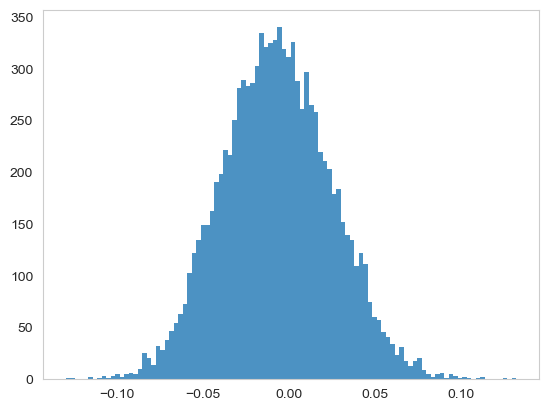

In [9]:
import matplotlib.pyplot as plt

plt.hist(
    profit_and_loss['Gov & MBS'],
    bins = 100,
    edgecolor = 'none',
    alpha = 0.8
)
plt.grid(False)
plt.show()

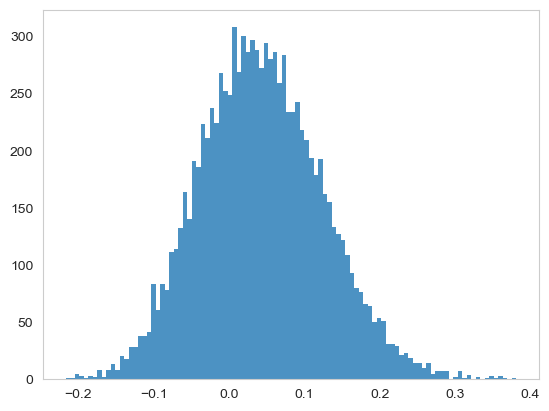

In [10]:
plt.hist(
    profit_and_loss['Real Estate'],
    bins = 100,
    edgecolor = 'none',
    alpha = 0.8
)
plt.grid(False)
plt.show()

In [11]:
instrument_names = profit_and_loss.columns

In [12]:
stats_prior = ft.simulation_moments(profit_and_loss)

In [13]:
stats_prior

,Mean,Volatility,Skewness,Kurtosis
Gov & MBS,-0.006976,0.031783,0.096295,3.022619
Corp IG,-0.003992,0.033873,0.106534,3.108871
Corp HY,0.019181,0.061198,0.173196,2.970604
EM Debt,0.027368,0.075091,0.217050,3.056793
DM Equity,0.063959,0.148501,0.396034,3.148418
EM Equity,0.080040,0.268654,0.766393,4.098948
Private Equity,0.136994,0.277711,0.716215,3.758005
Infrastructure,0.058655,0.108266,0.311013,3.192734
Real Estate,0.043207,0.081489,0.234063,3.092417
Hedge Funds,0.048017,0.072393,0.204416,3.050429


In [14]:
stats_prior.iloc[:, :2] = stats_prior.iloc[:, 0:2].mul(100)

In [15]:
display(np.round(stats_prior, 2))

,Mean,Volatility,Skewness,Kurtosis
Gov & MBS,-0.70,3.18,0.10,3.02
Corp IG,-0.40,3.39,0.11,3.11
Corp HY,1.92,6.12,0.17,2.97
EM Debt,2.74,7.51,0.22,3.06
DM Equity,6.40,14.85,0.40,3.15
EM Equity,8.00,26.87,0.77,4.10
Private Equity,13.70,27.77,0.72,3.76
Infrastructure,5.87,10.83,0.31,3.19
Real Estate,4.32,8.15,0.23,3.09
Hedge Funds,4.80,7.24,0.20,3.05


In [16]:
corr_prior = ft.correlation_matrix(profit_and_loss)

In [17]:
display(np.round(100 * corr_prior))

,0,1,2,3,4,5,6,7,8,9
"(0, Gov & MBS)",100.0,60.0,-0.0,30.0,-20.0,-10.0,-30.0,-10.0,-20.0,-20.0
"(1, Corp IG)",60.0,100.0,50.0,60.0,10.0,20.0,10.0,10.0,10.0,30.0
"(2, Corp HY)",-0.0,50.0,100.0,60.0,60.0,69.0,59.0,30.0,30.0,70.0
"(3, EM Debt)",30.0,60.0,60.0,100.0,40.0,59.0,30.0,20.0,20.0,40.0
"(4, DM Equity)",-20.0,10.0,60.0,40.0,100.0,69.0,79.0,40.0,40.0,80.0
"(5, EM Equity)",-10.0,20.0,69.0,59.0,69.0,100.0,69.0,30.0,39.0,79.0
"(6, Private Equity)",-30.0,10.0,59.0,30.0,79.0,69.0,100.0,39.0,49.0,79.0
"(7, Infrastructure)",-10.0,10.0,30.0,20.0,40.0,30.0,39.0,100.0,40.0,40.0
"(8, Real Estate)",-20.0,10.0,30.0,20.0,40.0,39.0,49.0,40.0,100.0,50.0
"(9, Hedge Funds)",-20.0,30.0,70.0,40.0,80.0,79.0,79.0,40.0,50.0,100.0


In [18]:
R = profit_and_loss.values
S = profit_and_loss.shape[0]
p = np.ones((S, 1)) / S
means_prior = p.T @ R
vols_prior = np.sqrt(p.T @ (R - means_prior) ** 2)

In [19]:
mean_rows = R[:, 2:7].T
vol_rows = (R[:, 2:6] - means_prior[:, 2:6]).T ** 2
skew_row = ((R[:, 4] - means_prior[:, 4]) / vols_prior[:, 4])**3
kurt_row = ((R[:, 4] - means_prior[:, 4]) / vols_prior[:, 4])**4
corr_row = (R[:, 2] - means_prior[:, 2]) * (R[:, 3] - means_prior[:, 3])

In [20]:
A = np.vstack((np.ones((1, S)), mean_rows, vol_rows[0:-1, :], corr_row[np.newaxis, :]))
b = np.vstack(
    ([1], means_prior[:, 2:6].T, [0.1], vols_prior[:, 2:5].T**2,
    [0.5 * vols_prior[0, 2] * vols_prior[0, 3]])
)
G = np.vstack((vol_rows[-1, :], skew_row, - kurt_row))
h = np.array([[0.2**2], [-0.75], [-3.5]])

In [21]:
q = entropy_pooling(p, A, b, G, h)
relative_entropy = q.T @ (np.log(q) - np.log(p))
effective_number_scenarios = np.exp(-relative_entropy)

In [22]:
stats_post = ft.simulation_moments(profit_and_loss, q)
stats_post.iloc[:, 0:2] = stats_post.iloc[:, 0:2].mul(100)
display(np.round(stats_post, 2))

,Mean,Volatility,Skewness,Kurtosis
Gov & MBS,-0.57,3.23,0.06,2.91
Corp IG,-0.51,3.43,0.14,3.12
Corp HY,1.92,6.12,-0.06,2.97
EM Debt,2.74,7.51,0.13,3.07
DM Equity,6.40,14.85,-0.75,3.50
EM Equity,8.00,20.00,-0.22,3.34
Private Equity,10.00,24.29,0.12,3.17
Infrastructure,5.65,10.65,0.28,3.16
Real Estate,3.75,8.02,0.13,3.02
Hedge Funds,4.64,6.95,-0.62,3.81


In [23]:
print(f'effective number of scenarios = {np.round(effective_number_scenarios[0, 0] * 100, 2)}%.')
print(f'relative entropy = {np.round(relative_entropy[0, 0] * 100, 2)}%.')

effective number of scenarios = 70.92%.
relative entropy = 34.36%.


In [24]:
corr_post = ft.correlation_matrix(profit_and_loss, q)
display(np.round(100 * corr_post))

,0,1,2,3,4,5,6,7,8,9
"(0, Gov & MBS)",100.0,60.0,-2.0,35.0,-23.0,-10.0,-34.0,-10.0,-20.0,-24.0
"(1, Corp IG)",60.0,100.0,51.0,63.0,9.0,20.0,7.0,9.0,11.0,29.0
"(2, Corp HY)",-2.0,51.0,100.0,50.0,57.0,64.0,55.0,27.0,27.0,67.0
"(3, EM Debt)",35.0,63.0,50.0,100.0,31.0,51.0,16.0,16.0,15.0,29.0
"(4, DM Equity)",-23.0,9.0,57.0,31.0,100.0,66.0,76.0,37.0,38.0,79.0
"(5, EM Equity)",-10.0,20.0,64.0,51.0,66.0,100.0,62.0,27.0,36.0,75.0
"(6, Private Equity)",-34.0,7.0,55.0,16.0,76.0,62.0,100.0,38.0,47.0,76.0
"(7, Infrastructure)",-10.0,9.0,27.0,16.0,37.0,27.0,38.0,100.0,39.0,38.0
"(8, Real Estate)",-20.0,11.0,27.0,15.0,38.0,36.0,47.0,39.0,100.0,49.0
"(9, Hedge Funds)",-24.0,29.0,67.0,29.0,79.0,75.0,76.0,38.0,49.0,100.0


<Axes: >

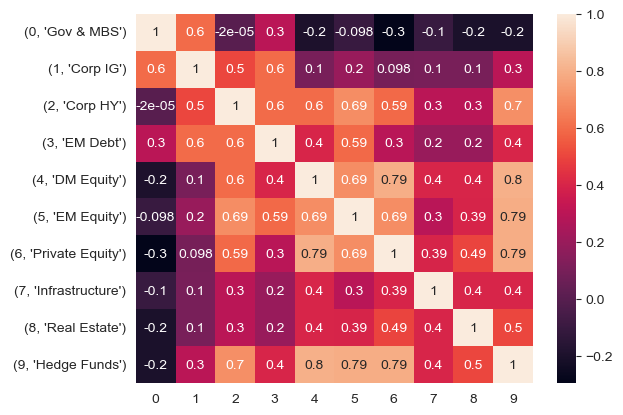

In [25]:
import seaborn as sns

sns.heatmap(corr_prior, annot = True)

<Axes: >

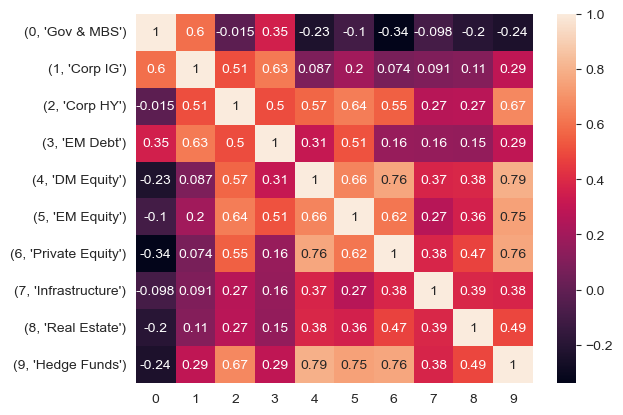

In [26]:
sns.heatmap(corr_post, annot = True)

### Empirical Market Data

In [74]:
import yfinance as yf
import pandas as pd

start_date = '1999-12-29'
end_date = '2024-03-12'
tickers = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'PYPL', 'ADBE', 'INTC', 'CSCO', 'CMCSA', 'PEP'
]
price = pd.DataFrame()
for i in tickers :
    price = pd.concat([
        price, 
        yf.download(i, start=start_date, end=end_date)['Close']
    ], axis = 1)
price.columns = tickers
price.index = pd.to_datetime(price.index)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [75]:
price.dropna(inplace=True)

In [76]:
ret = price.pct_change().dropna()

ret_test = ret['2020-01' :]
ret = ret[: '2019-12']

In [77]:
asset_names = ret.columns

In [78]:
stats_prior = ft.simulation_moments(ret)

In [79]:
stats_prior

,Mean,Volatility,Skewness,Kurtosis
AAPL,0.000873,0.015784,-0.280909,6.968473
MSFT,0.001224,0.014326,0.252707,8.163597
GOOGL,0.000909,0.015212,0.985415,17.478311
AMZN,0.001439,0.018027,0.441764,9.542613
PYPL,0.001118,0.018042,0.176625,6.317401
ADBE,0.001391,0.016929,0.105135,9.252045
INTC,0.000741,0.016170,-0.106784,8.485943
CSCO,0.000603,0.014270,-0.325029,8.608268
CMCSA,0.000419,0.013513,-0.285534,5.896774
PEP,0.000370,0.009197,-0.197471,5.524308


In [80]:
stats_prior.iloc[:, :2] = stats_prior.iloc[:, 0:2].mul(100)

In [81]:
stats_prior

,Mean,Volatility,Skewness,Kurtosis
AAPL,0.087331,1.578364,-0.280909,6.968473
MSFT,0.122380,1.432625,0.252707,8.163597
GOOGL,0.090899,1.521186,0.985415,17.478311
AMZN,0.143922,1.802718,0.441764,9.542613
PYPL,0.111833,1.804211,0.176625,6.317401
ADBE,0.139080,1.692927,0.105135,9.252045
INTC,0.074057,1.616958,-0.106784,8.485943
CSCO,0.060309,1.426991,-0.325029,8.608268
CMCSA,0.041895,1.351323,-0.285534,5.896774
PEP,0.036956,0.919737,-0.197471,5.524308


In [82]:
corr_prior = ft.correlation_matrix(ret)

<Axes: >

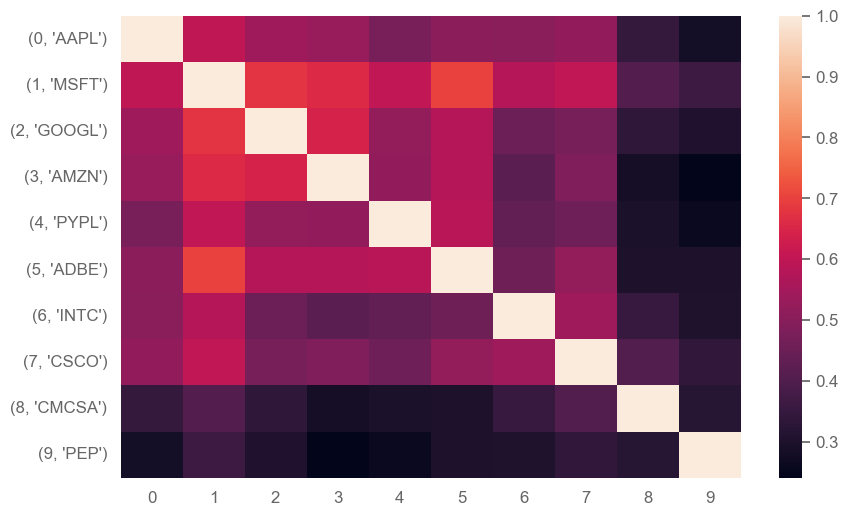

In [83]:
sns.heatmap(corr_prior)

In [84]:
R = ret.values
S = ret.shape[0]
p = np.ones((S, 1)) / S
means_prior = p.T @ R
vols_prior = np.sqrt(p.T @ (R - means_prior) ** 2)

In [85]:
means_prior

array([[0.00087331, 0.0012238 , 0.00090899, 0.00143922, 0.00111833,
        0.0013908 , 0.00074057, 0.00060309, 0.00041895, 0.00036956]])

In [86]:
vols_prior

array([[0.01578364, 0.01432625, 0.01521186, 0.01802718, 0.01804211,
        0.01692927, 0.01616958, 0.01426991, 0.01351323, 0.00919737]])

In [87]:
mean_rows = R[:, 5:].T  # 평균 행, 여기서는 첫 5개 자산을 사용
vol_rows = (R[:, 5:] - means_prior[:, 5:]).T ** 2  # 변동성 행, 첫 5개 자산
skew_row = ((R[:, -1] - means_prior[:, -1]) / vols_prior[:, -1]) ** 3  # 왜도 행, 5번째 자산
kurt_row = ((R[:, -1] - means_prior[:, -1]) / vols_prior[:, -1]) ** 4  # 첨도 행, 5번째 자산
corr_row = (R[:, -2] - means_prior[:, -2]) * (R[:, -1] - means_prior[:, -1])

In [88]:
A = np.vstack((np.ones((1, S)), mean_rows, vol_rows[:-1, :], corr_row))# 상관관계 행은 제외
b = np.vstack(([1], means_prior[:, :5].T, [0.1], vols_prior[:, :4].T ** 2))
G = np.vstack((vol_rows[-1, :], skew_row, -kurt_row))
h = np.array([[0.01], [-0.8], [-3]])

In [89]:
q = entropy_pooling(p, A, b, G, h)
relative_entropy = q.T @ (np.log(q) - np.log(p))
effective_number_scenarios = np.exp(-relative_entropy)

/var/folders/7g/v3wmln7x2mv8wqmn923x0qy40000gn/T/ipykernel_27866/4003731696.py:62: RuntimeWarning: overflow encountered in exp
  x = np.exp(log_x)
/var/folders/7g/v3wmln7x2mv8wqmn923x0qy40000gn/T/ipykernel_27866/4003731696.py:63: RuntimeWarning: invalid value encountered in matmul
  gradient = rhs - lhs @ x
/var/folders/7g/v3wmln7x2mv8wqmn923x0qy40000gn/T/ipykernel_27866/4003731696.py:64: RuntimeWarning: invalid value encountered in matmul
  objective = x.T @ (log_x - log_p) - lagrange_multipliers.T @ gradient


In [90]:
stats_post = ft.simulation_moments(ret, q)
#stats_post.iloc[:, 0:2] = stats_post.iloc[:, 0:2].mul(100)
display(np.round(stats_post, 2))

,Mean,Volatility,Skewness,Kurtosis
AAPL,-0.01,0.01,-1.97,3.89
MSFT,-0.01,0.01,-2.03,4.46
GOOGL,-0.01,0.01,-2.18,4.76
AMZN,-0.01,0.02,-2.18,4.77
PYPL,-0.01,0.02,-2.12,4.62
ADBE,-0.01,0.04,0.51,5.46
INTC,-0.01,0.01,-2.18,4.77
CSCO,-0.01,0.01,-1.92,4.28
CMCSA,0.01,0.01,1.95,3.84
PEP,0.00,0.00,3.82,16.20


In [91]:
corr_post = ft.correlation_matrix(ret, q)

In [92]:
corr_post

,0,1,2,3,4,5,6,7,8,9
"(0, AAPL)",1.000000,0.960606,0.962973,0.956723,0.961804,0.961089,0.954183,0.952737,-0.250933,0.943175
"(1, MSFT)",0.960606,1.000000,0.999963,0.999907,0.999991,0.999998,0.999752,0.999634,-0.510070,0.998369
"(2, GOOGL)",0.962973,0.999963,1.000000,0.999751,0.999991,0.999976,0.999523,0.999363,-0.502615,0.997839
"(3, AMZN)",0.956723,0.999907,0.999751,1.000000,0.999838,0.999882,0.999963,0.999910,-0.521762,0.999056
"(4, PYPL)",0.961804,0.999991,0.999991,0.999838,1.000000,0.999997,0.999646,0.999507,-0.506331,0.998112
"(5, ADBE)",0.961089,0.999998,0.999976,0.999882,0.999997,1.000000,0.999712,0.999585,-0.508569,0.998268
"(6, INTC)",0.954183,0.999752,0.999523,0.999963,0.999646,0.999712,1.000000,0.999989,-0.529087,0.999393
"(7, CSCO)",0.952737,0.999634,0.999363,0.999910,0.999507,0.999585,0.999989,1.000000,-0.533150,0.999548
"(8, CMCSA)",-0.250933,-0.510070,-0.502615,-0.521762,-0.506331,-0.508569,-0.529087,-0.533150,1.000000,-0.558338
"(9, PEP)",0.943175,0.998369,0.997839,0.999056,0.998112,0.998268,0.999393,0.999548,-0.558338,1.000000


<Axes: >

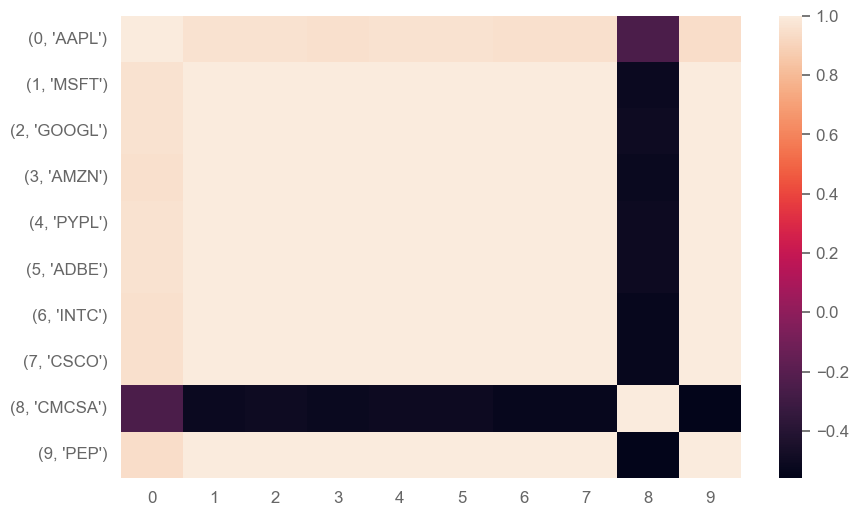

In [93]:
sns.heatmap(corr_post)

In [94]:
variances = stats_post['Volatility'] ** 2
covariance_matrix = np.outer(variances, variances) * corr_post  # 공분산 행렬

In [95]:
# 포트폴리오 변동성 함수 정의
def portfolio_volatility(weights, covariance_matrix):
    # 포트폴리오 변동성 계산
    portfolio_variance = np.dot(weights.T, np.dot(covariance_matrix, weights))
    portfolio_volatility = np.sqrt(portfolio_variance)
    return portfolio_volatility

In [96]:
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
initial_weights = np.array([0.1 for i in range(10)])
bounds = tuple((0, 1) for asset in range(len(stats_post['Mean'])))

opt_result = minimize(portfolio_volatility, initial_weights, args=(covariance_matrix,),
                      method='SLSQP', bounds=bounds, constraints=constraints)

optimal_weights = opt_result.x

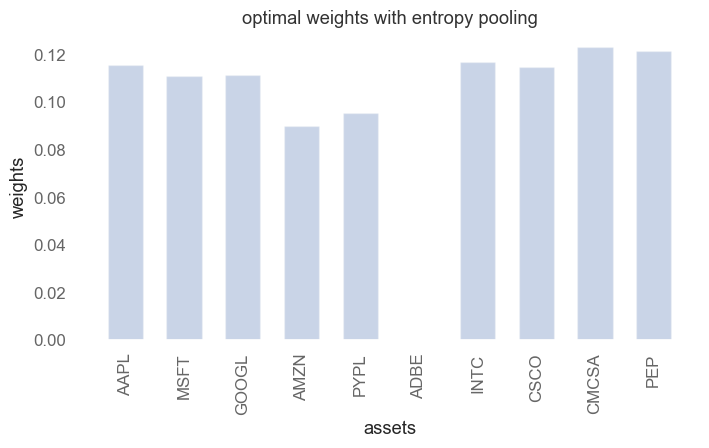

In [97]:
plt.figure(figsize = (8, 4))
plt.bar(asset_names, optimal_weights, alpha = 0.3, color = 'b', width = 0.6)
plt.grid(False)
plt.xticks(rotation = 90)
plt.title('optimal weights with entropy pooling')
plt.ylabel('weights')
plt.xlabel('assets')
plt.show()

In [98]:
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

initial_weights = np.array([0.1 for i in range(10)])

bounds = tuple((0, 1) for asset in range(len(ret.mean())))

opt_result = minimize(
    portfolio_volatility, 
    initial_weights, 
    args=(ret.cov(),),
    method='SLSQP', 
    bounds=bounds, 
    constraints=constraints
)

optimal_weights_cov = opt_result.x

optimal_weights_cov

array([4.09189938e-02, 8.02309608e-18, 4.75149685e-02, 2.11767435e-02,
       1.44993839e-02, 0.00000000e+00, 2.64909097e-02, 5.17541796e-02,
       1.58873905e-01, 6.38770916e-01])

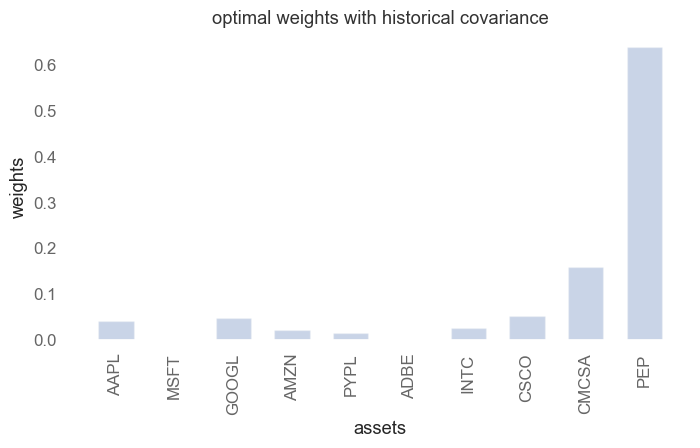

In [99]:
plt.figure(figsize = (8, 4))
plt.bar(asset_names, optimal_weights_cov, alpha = 0.3, color = 'b', width = 0.6)
plt.grid(False)
plt.xticks(rotation = 90)
plt.title('optimal weights with historical covariance')
plt.ylabel('weights')
plt.xlabel('assets')
plt.show()

Text(0.5, 1.0, 'portfolio optimization')

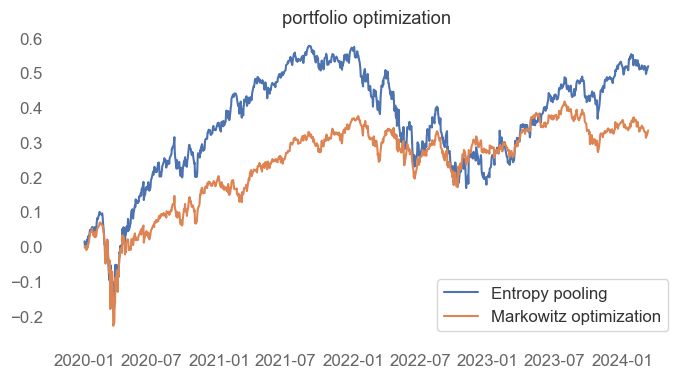

In [100]:
plt.figure(figsize = (8, 4))
plt.plot((ret_test * optimal_weights).sum(axis = 1).cumsum(), label = 'Entropy pooling')
plt.plot((ret_test * optimal_weights_cov).sum(axis = 1).cumsum(), label = 'Markowitz optimization')
plt.legend()
plt.grid(False)
plt.title('portfolio optimization')

### Other Metrics

In [101]:
from FinancialMachineLearning.metrics.distance import DistanceDataFrame

In [102]:
corr_based_dist = DistanceDataFrame(ret).corr_based_distance()

In [103]:
def find_optimal_portfolio(returns, distance_matrix, risk_free_rate=0.0):
    n = returns.shape[1]
    mean_returns = returns.mean()

    def neg_sharpe_ratio(weights):
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_var = np.dot(weights.T, np.dot(distance_matrix, weights))
        portfolio_std = np.sqrt(portfolio_var)
        sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std
        return -sharpe_ratio 

    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},)
    bounds = tuple((0, 1) for _ in range(n))
    initial_weights = np.ones(n) / n

    result = minimize(neg_sharpe_ratio, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    
    optimal_weights = result.x
    optimal_weights = pd.Series(optimal_weights, index = returns.columns, name = 'weight')
    optimal_return = np.dot(optimal_weights, mean_returns)
    return optimal_weights, optimal_return

def find_optimal_portfolio_distance_maximization(returns, distance_matrix, risk_free_rate=0.0):
    n = returns.shape[1]
    mean_returns = returns.mean()

    def min_negative_entropy_based_measure(weights):
        diversity_measure = np.dot(weights.T, np.dot(distance_matrix, weights))
        return -diversity_measure

    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},)
    bounds = tuple((0, 1) for _ in range(n))
    initial_weights = np.ones(n) / n

    result = minimize(min_negative_entropy_based_measure, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    
    optimal_weights = result.x
    optimal_weights = pd.Series(optimal_weights, index=returns.columns, name='weight')
    
    optimal_diversity_measure = -min_negative_entropy_based_measure(optimal_weights)

    return optimal_weights, optimal_diversity_measure

In [104]:
optimal_weights_corr_based , _ = find_optimal_portfolio_distance_maximization(ret, corr_based_dist)

In [105]:
optimal_weights_corr_based

AAPL     0.091337
MSFT     0.000000
GOOGL    0.074597
AMZN     0.098572
PYPL     0.109977
ADBE     0.079040
INTC     0.110672
CSCO     0.079221
CMCSA    0.168498
PEP      0.188087
Name: weight, dtype: float64

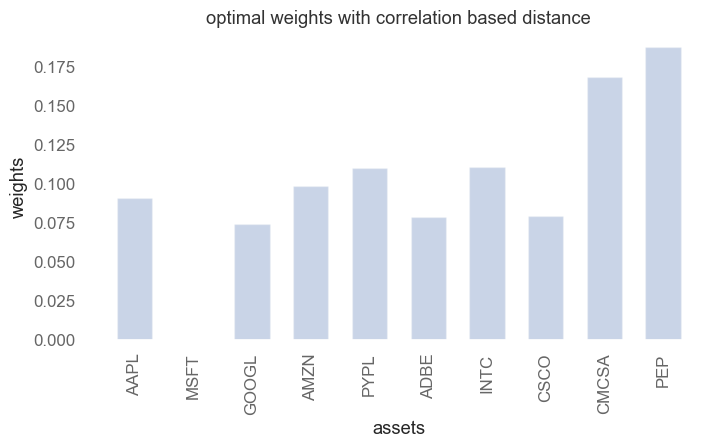

In [106]:
plt.figure(figsize = (8, 4))
plt.bar(asset_names, optimal_weights_corr_based, alpha = 0.3, color = 'b', width = 0.6)
plt.grid(False)
plt.xticks(rotation = 90)
plt.title('optimal weights with correlation based distance')
plt.ylabel('weights')
plt.xlabel('assets')
plt.show()

In [107]:
mutual_info = DistanceDataFrame(ret).mutual_information()

In [108]:
optimal_weights_mi , _ = find_optimal_portfolio(ret, mutual_info)

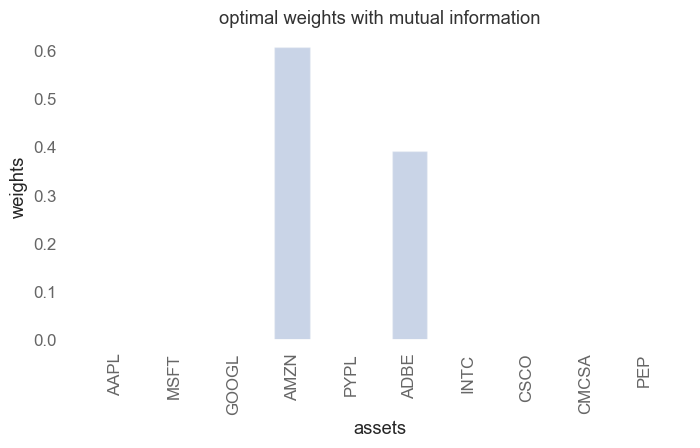

In [109]:
plt.figure(figsize = (8, 4))
plt.bar(asset_names, optimal_weights_mi, alpha = 0.3, color = 'b', width = 0.6)
plt.grid(False)
plt.xticks(rotation = 90)
plt.title('optimal weights with mutual information')
plt.ylabel('weights')
plt.xlabel('assets')
plt.show()

In [110]:
var_info = DistanceDataFrame(ret).variational_information()
optimal_weights_vi, _ = find_optimal_portfolio_distance_maximization(ret, var_info)

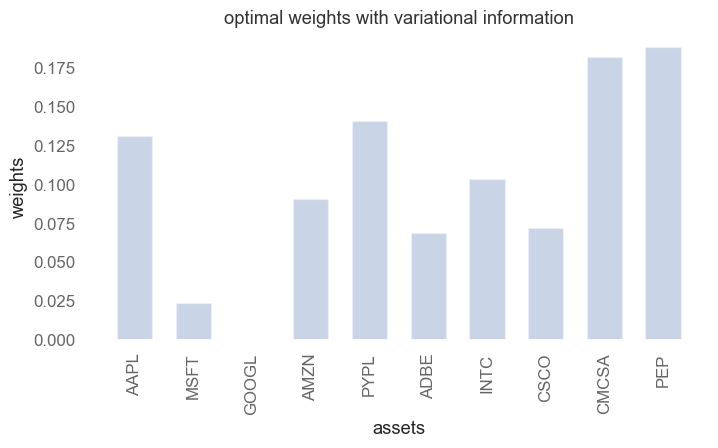

In [111]:
plt.figure(figsize = (8, 4))
plt.bar(asset_names, optimal_weights_vi, alpha = 0.3, color = 'b', width = 0.6)
plt.grid(False)
plt.xticks(rotation = 90)
plt.title('optimal weights with variational information')
plt.ylabel('weights')
plt.xlabel('assets')
plt.show()

In [112]:
js = DistanceDataFrame(ret).jensen_shannon_divergence()
optimal_weights_js, _ = find_optimal_portfolio_distance_maximization(ret, js)

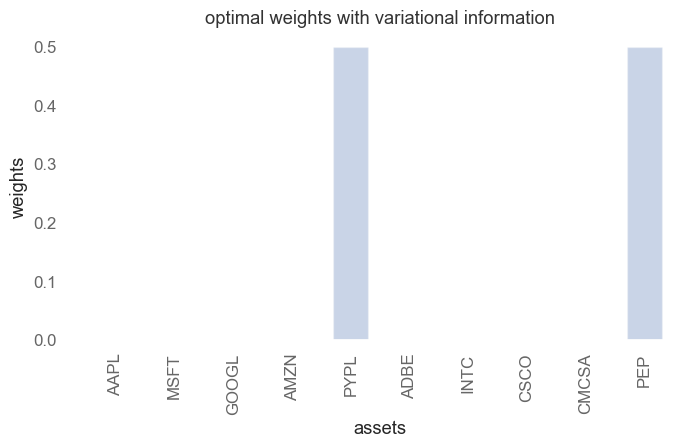

In [113]:
plt.figure(figsize = (8, 4))
plt.bar(asset_names, optimal_weights_js, alpha = 0.3, color = 'b', width = 0.6)
plt.grid(False)
plt.xticks(rotation = 90)
plt.title('optimal weights with variational information')
plt.ylabel('weights')
plt.xlabel('assets')
plt.show()

Text(0.5, 1.0, 'portfolio optimization')

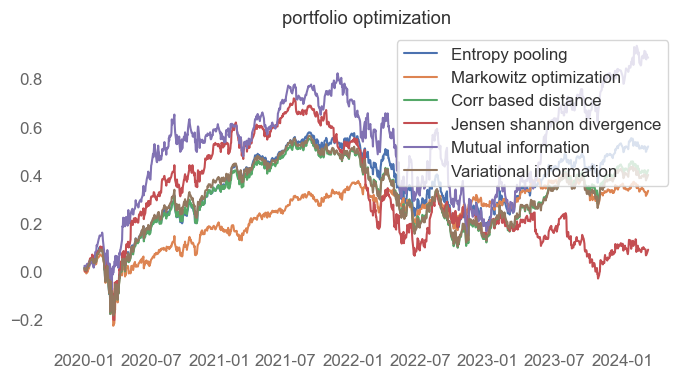

In [114]:
plt.figure(figsize = (8, 4))
plt.plot((ret_test * optimal_weights).sum(axis = 1).cumsum(), label = 'Entropy pooling')
plt.plot((ret_test * optimal_weights_cov).sum(axis = 1).cumsum(), label = 'Markowitz optimization')
plt.plot((ret_test * optimal_weights_corr_based).sum(axis = 1).cumsum(), label = 'Corr based distance')
plt.plot((ret_test * optimal_weights_js).sum(axis = 1).cumsum(), label = 'Jensen shannon divergence')
plt.plot((ret_test * optimal_weights_mi).sum(axis = 1).cumsum(), label = 'Mutual information')
plt.plot((ret_test * optimal_weights_vi).sum(axis = 1).cumsum(), label = 'Variational information')
plt.legend()
plt.grid(False)
plt.title('portfolio optimization')

In [115]:
import quantstats as qs

In [116]:
backtest = pd.concat(
    [
        (ret_test * optimal_weights).sum(axis = 1),
        (ret_test * optimal_weights_cov).sum(axis = 1),
        (ret_test * optimal_weights_corr_based).sum(axis = 1),
        (ret_test * optimal_weights_js).sum(axis = 1),
        (ret_test * optimal_weights_mi).sum(axis = 1),
        (ret_test * optimal_weights_vi).sum(axis = 1)
    ], axis = 1
)
backtest.columns = [
    'Entropy Pooling','Markowiz', 'Correlation Distance', 'Jensen-Shannon Divergence', 'Mutual Information', 'Variational Information'
]

In [117]:
backtest.index = pd.to_datetime(backtest.index)

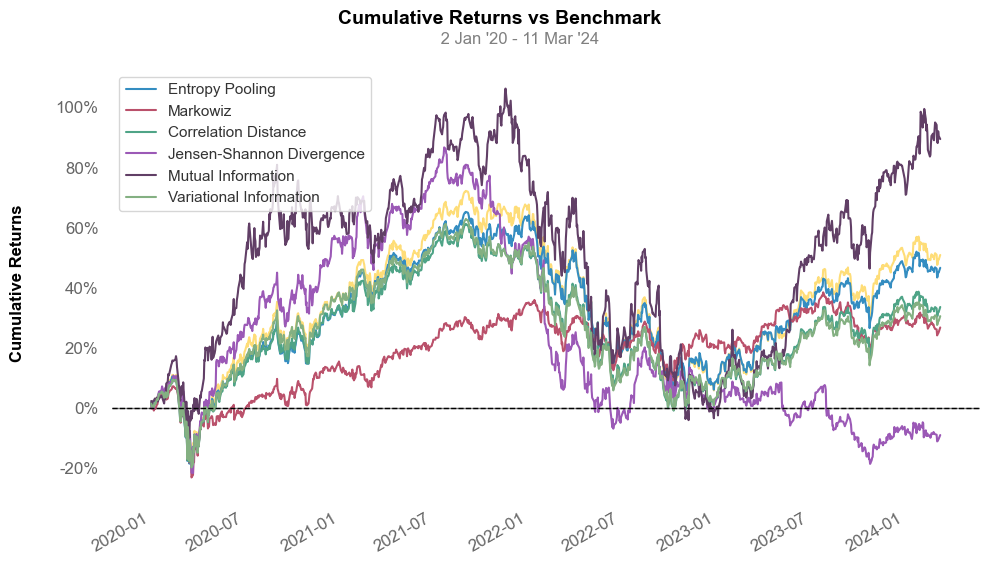

In [118]:
plt.rcParams["axes.grid"] = False  # 모든 플롯에 대해 그리드 비활성화
qs.plots.returns(
    backtest,
    benchmark = ret_test.mean(axis = 1),
)

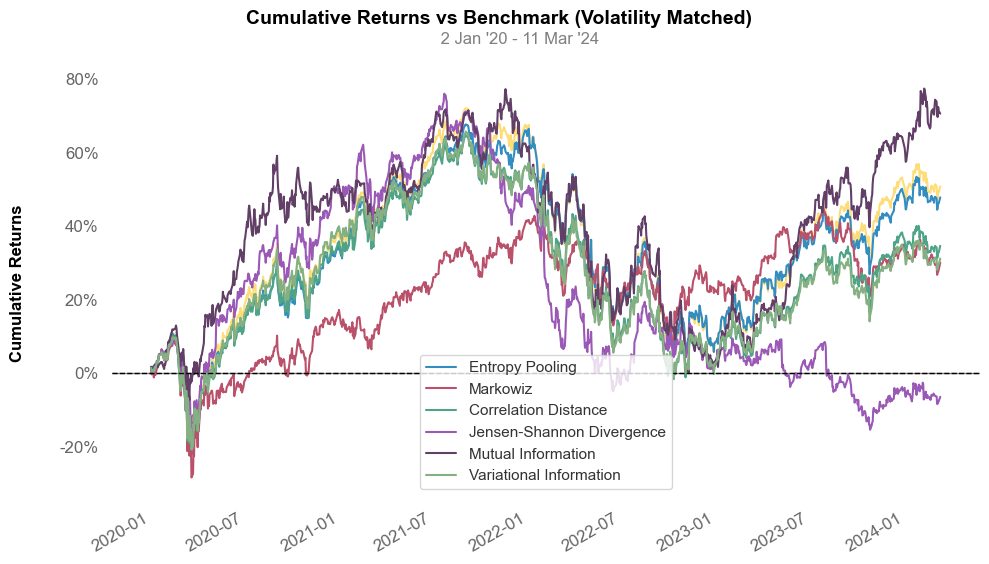

In [119]:
qs.plots.returns(
    backtest,
    benchmark = ret_test.mean(axis = 1),
    match_volatility = True
)

In [120]:
qs.reports.metrics(backtest, benchmark = ret_test.mean(axis = 1))

                    Benchmark    Entropy Pooling    Markowiz    Correlation Distance    Jensen-Shannon Divergence    Mutual Information    Variational Information
------------------  -----------  -----------------  ----------  ----------------------  ---------------------------  --------------------  -------------------------
Start Period        2020-01-02   2020-01-02         2020-01-02  2020-01-02              2020-01-02                   2020-01-02            2020-01-02
End Period          2024-03-11   2024-03-11         2024-03-11  2024-03-11              2024-03-11                   2024-03-11            2024-03-11
Risk-Free Rate      0.0%         0.0%               0.0%        0.0%                    0.0%                         0.0%                  0.0%
Time in Market      100.0%       100.0%             100.0%      100.0%                  100.0%                       100.0%                100.0%

Cumulative Return   50.82%       46.55%             26.67%      33.5%            

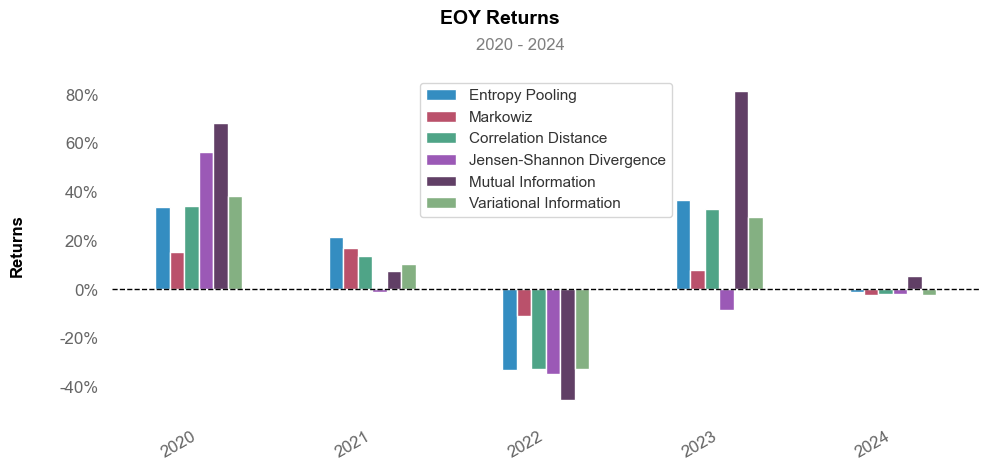

In [121]:
qs.plots.yearly_returns(
    returns = backtest,
)

In [122]:
def simulate_ou_assets_and_calculate_sharpe(mu_values, sigma_values, theta, T, dt, weights, num_trials):
    num_steps = int(T / dt)
    num_assets = len(mu_values)
    sharpe_ratios = np.zeros(num_trials)

    for trial in range(num_trials):
        portfolio_returns = np.zeros(num_steps)
        for asset in range(num_assets):
            mu = mu_values[asset]
            sigma = sigma_values[asset]
            x = np.zeros(num_steps)
            x[0] = mu  # 초기값 설정
            for t in range(1, num_steps):
                dW = np.random.normal(0, np.sqrt(dt))
                x[t] = x[t-1] + theta * (mu - x[t-1]) * dt + sigma * dW
            portfolio_returns += weights[asset] * x  # 가중치를 적용한 자산 수익률을 포트폴리오 수익률에 추가
        excess_returns = portfolio_returns - portfolio_returns[0]
        sharpe_ratios[trial] = np.mean(excess_returns) / np.std(excess_returns) if np.std(excess_returns) != 0 else 0

    return sharpe_ratios

In [141]:
mu_values = stats_post['Mean']
sigma_values = stats_post['Volatility']
theta = 0.5
T = 1
dt = 0.001
num_trials = 500

In [142]:
sharpe_ratios_ep = simulate_ou_assets_and_calculate_sharpe(ret.mean(), ret.std(), theta, T, dt, optimal_weights, num_trials)
sharpe_ratios_markowitz = simulate_ou_assets_and_calculate_sharpe(ret.mean(), ret.std(), theta, T, dt, optimal_weights_cov, num_trials)
sharpe_ratios_corr_dist = simulate_ou_assets_and_calculate_sharpe(ret.mean(), ret.std(), theta, T, dt, optimal_weights_corr_based, num_trials)
sharpe_ratios_mi = simulate_ou_assets_and_calculate_sharpe(ret.mean(), ret.std(), theta, T, dt, optimal_weights_mi, num_trials)
sharpe_ratios_vi = simulate_ou_assets_and_calculate_sharpe(ret.mean(), ret.std(), theta, T, dt, optimal_weights_vi, num_trials)
sharpe_ratios_js = simulate_ou_assets_and_calculate_sharpe(ret.mean(), ret.std(), theta, T, dt, optimal_weights_js, num_trials)

Text(0.5, 1.0, 'Estimated Sharpe Ratio using Entropy Pooling')

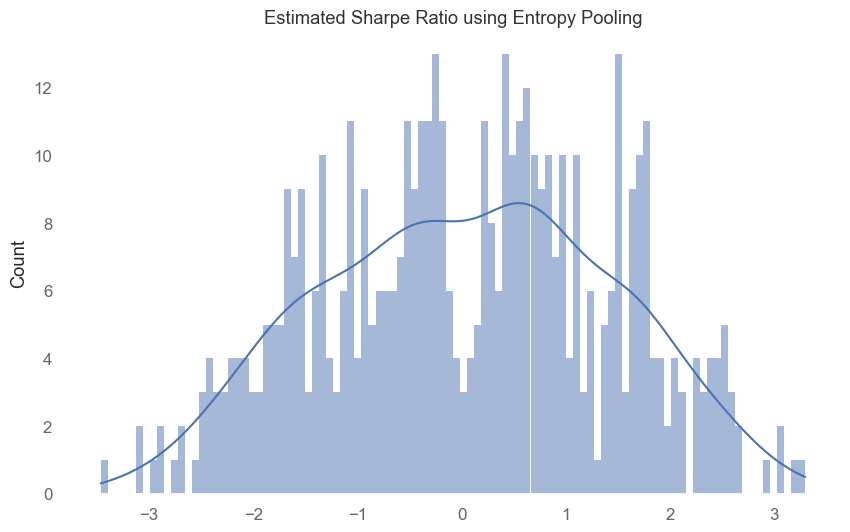

In [143]:
sns.histplot(sharpe_ratios_ep, edgecolor = 'none', bins = 100, kde = True)
plt.title('Estimated Sharpe Ratio using Entropy Pooling')

Text(0.5, 1.0, 'Estimated Sharpe Ratio using corr based dist')

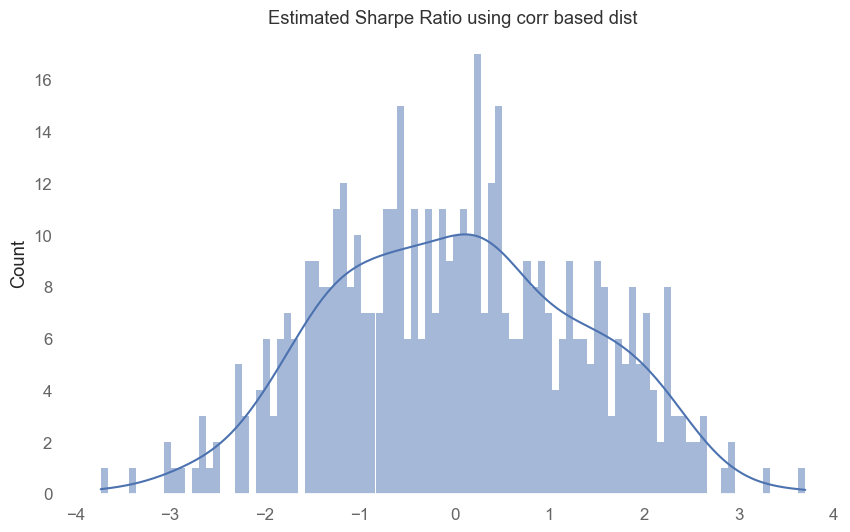

In [144]:
sns.histplot(sharpe_ratios_corr_dist, edgecolor = 'none', bins = 100, kde = True)
plt.title('Estimated Sharpe Ratio using corr based dist')

Text(0.5, 1.0, 'Estimated Sharpe Ratio using mutual information')

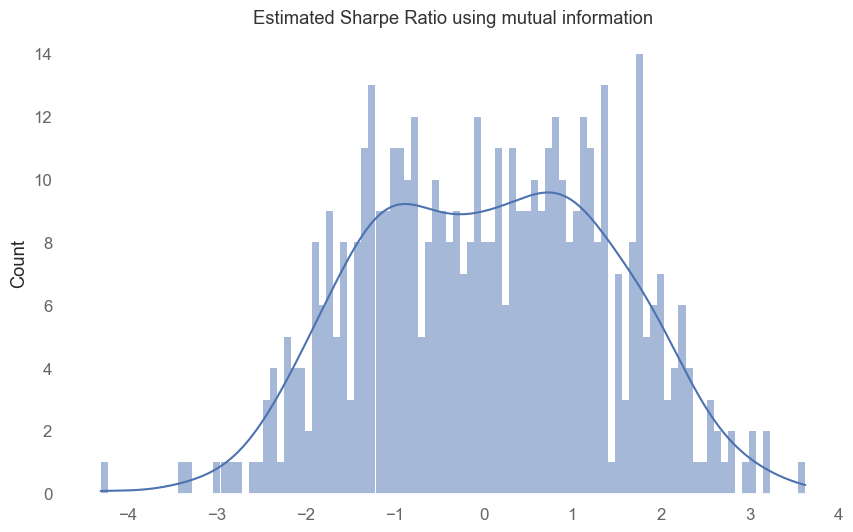

In [145]:
sns.histplot(sharpe_ratios_mi, edgecolor = 'none', bins = 100, kde = True)
plt.title('Estimated Sharpe Ratio using mutual information')

Text(0.5, 1.0, 'Estimated Sharpe Ratio using variational information')

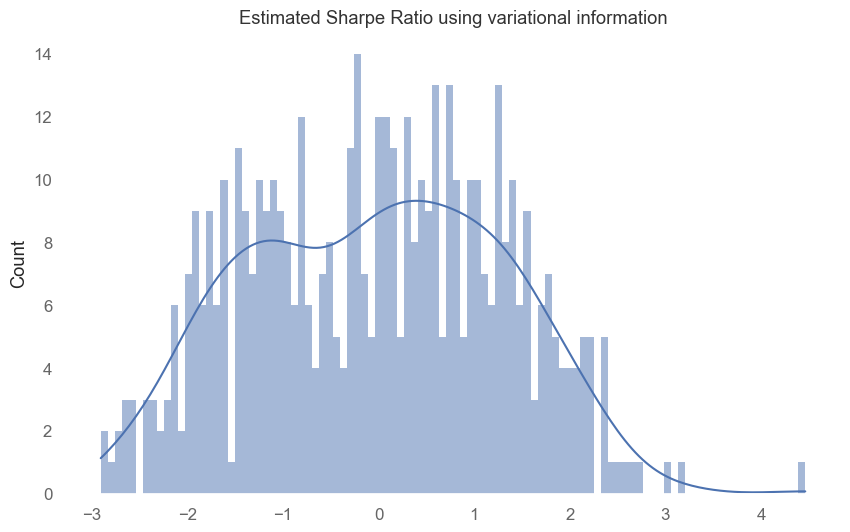

In [146]:
sns.histplot(sharpe_ratios_vi, edgecolor = 'none', bins = 100, kde = True)
plt.title('Estimated Sharpe Ratio using variational information')

Text(0.5, 1.0, 'Estimated Sharpe Ratio using markowitz')

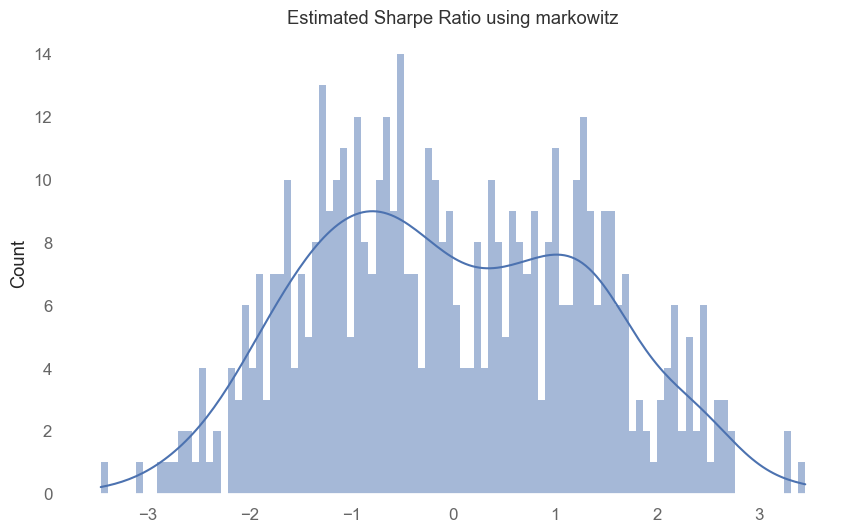

In [147]:
sns.histplot(sharpe_ratios_markowitz, edgecolor = 'none', bins = 100, kde = True)
plt.title('Estimated Sharpe Ratio using markowitz')

Text(0.5, 1.0, 'Estimated Sharpe Ratio using jensen-shannon divergence')

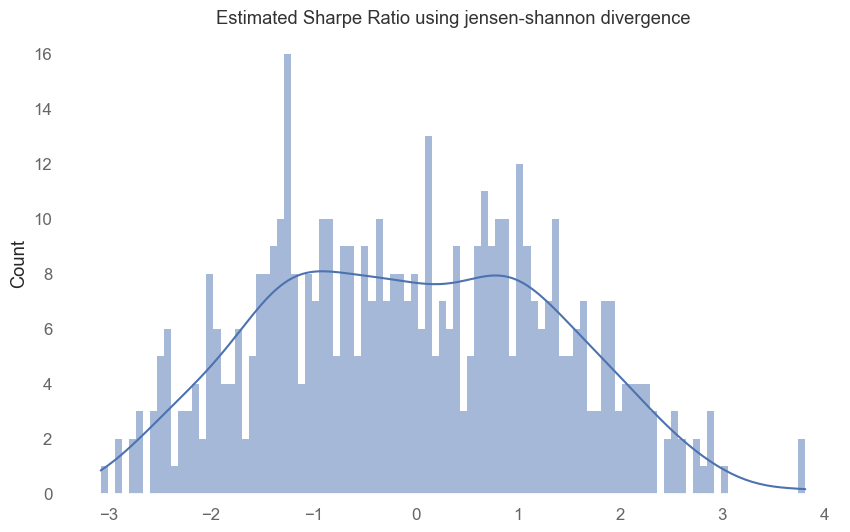

In [148]:
sns.histplot(sharpe_ratios_js, edgecolor = 'none', bins = 100, kde = True)
plt.title('Estimated Sharpe Ratio using jensen-shannon divergence')

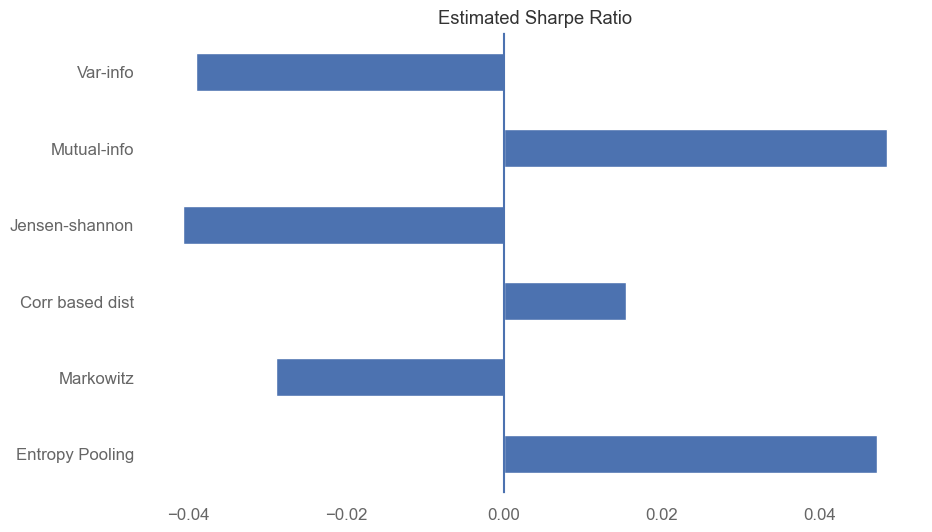

In [149]:
plt.barh(
    ['Entropy Pooling','Markowitz','Corr based dist','Jensen-shannon','Mutual-info','Var-info'],
    [sharpe_ratios_ep.mean(), sharpe_ratios_markowitz.mean(), sharpe_ratios_corr_dist.mean(), sharpe_ratios_js.mean(), sharpe_ratios_mi.mean(), sharpe_ratios_vi.mean()],
    height = 0.5
)
plt.title('Estimated Sharpe Ratio')
plt.axvline(0)

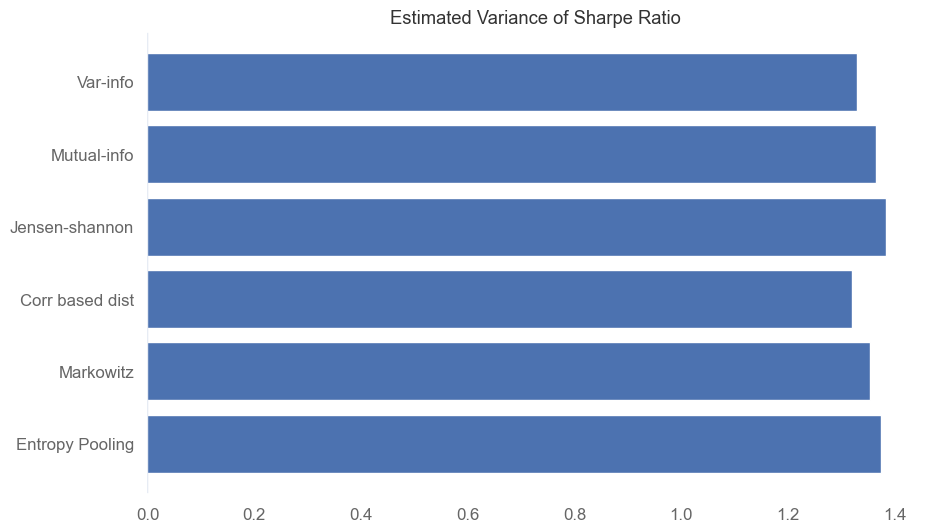

In [150]:
plt.barh(
    ['Entropy Pooling','Markowitz','Corr based dist','Jensen-shannon','Mutual-info','Var-info'],
    [sharpe_ratios_ep.std(), sharpe_ratios_markowitz.std(), sharpe_ratios_corr_dist.std(), sharpe_ratios_js.std(), sharpe_ratios_mi.std(), sharpe_ratios_vi.std()]
)
plt.title('Estimated Variance of Sharpe Ratio')
plt.axvline(0)

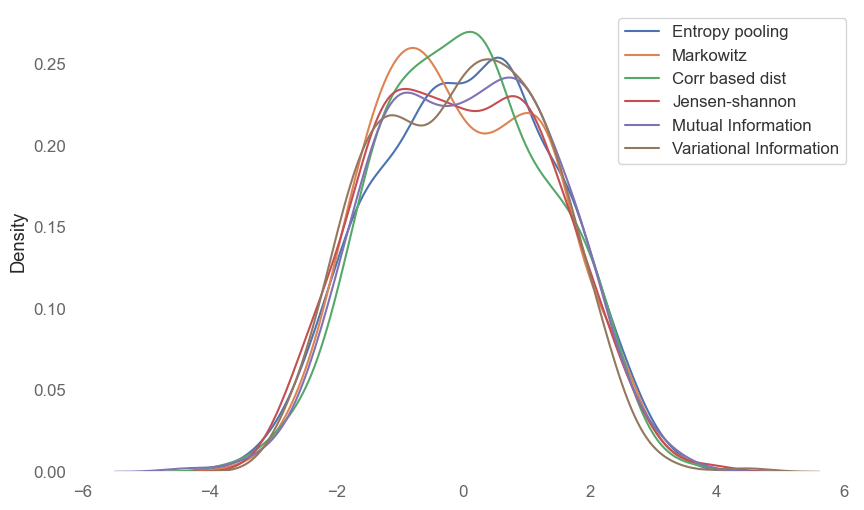

In [151]:
sns.kdeplot(sharpe_ratios_ep, label = 'Entropy pooling')
sns.kdeplot(sharpe_ratios_markowitz, label = 'Markowitz')
sns.kdeplot(sharpe_ratios_corr_dist, label = 'Corr based dist')
sns.kdeplot(sharpe_ratios_js, label = 'Jensen-shannon')
sns.kdeplot(sharpe_ratios_mi, label = 'Mutual Information')
sns.kdeplot(sharpe_ratios_vi, label = 'Variational Information')
plt.legend()